In [2]:
import torch # 파이토치 기본 라이브러리 
import torchvision # 이미지 관련 된 파이토치 라이브러리
from torchvision import datasets # 토치비전에서 제공하는 데이터셋
from torchvision import transforms # 이미지 전처리 기능들을 제공하는 라이브러리
from torch.utils.data import DataLoader # 데이터를 모델에 사용할 수 있도록 적재해 주는 라이브러리
from torch.utils.data import random_split
import numpy as np 
import matplotlib.pyplot as plt

In [3]:
!nvidia-smi

Thu Jan 12 16:41:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
%pwd

'/kaggle/working'

In [6]:
data_dir = '../input/hotdognothotdog'

In [7]:
!ls ../input/

hotdognothotdog


In [8]:
#transform = transforms.Compose([transforms.ToTensor()]) 

In [9]:
transform = transforms.Compose([transforms.Resize([299, 299]), 
                                transforms.RandomHorizontalFlip(0.2),
                                transforms.RandomRotation(degrees = (0, 20)),
                                transforms.ToTensor()
                               ]) 

In [10]:
trainset = datasets.ImageFolder(root= data_dir + '/hotdog-nothotdog/train', transform=transform)
testset = datasets.ImageFolder(root= data_dir + '/hotdog-nothotdog/test', transform=transform)

In [11]:
trainset, validset = random_split(trainset, [2400, 600])

In [12]:
print(type(trainset), len(trainset)) # 3000
print(type(validset), len(validset))
print(type(testset), len(testset)) # 644

<class 'torch.utils.data.dataset.Subset'> 2400
<class 'torch.utils.data.dataset.Subset'> 600
<class 'torchvision.datasets.folder.ImageFolder'> 644


In [13]:
# 1번 샘플
sample_img = trainset[1][0]
sample_img.size()

torch.Size([3, 299, 299])

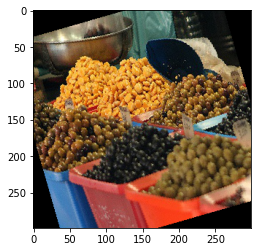

In [14]:
plt.imshow(sample_img.permute(1, 2, 0))

In [15]:
sample_img.size()

torch.Size([3, 299, 299])

In [16]:
numpy_sample = sample_img.numpy()
numpy_sample.shape

(3, 299, 299)

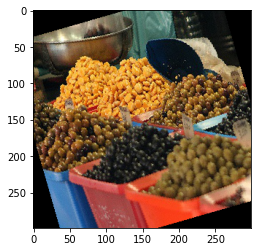

In [17]:
plt.imshow(numpy_sample.transpose(1, 2, 0))

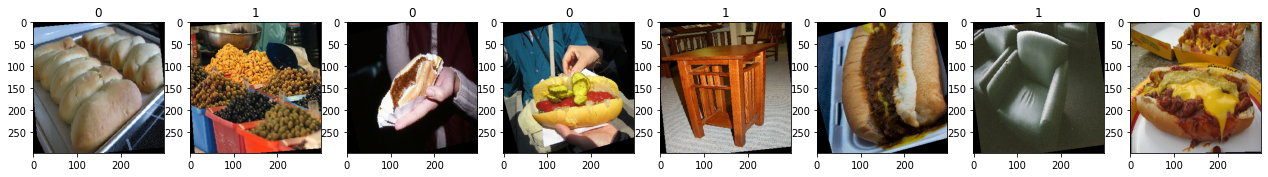

In [18]:
figure, axes = plt.subplots(nrows=1, ncols=8, figsize=(22, 6))
for i in range(8):
    axes[i].imshow(trainset[i][0].permute(1, 2, 0))
    axes[i].set_title(trainset[i][1])   

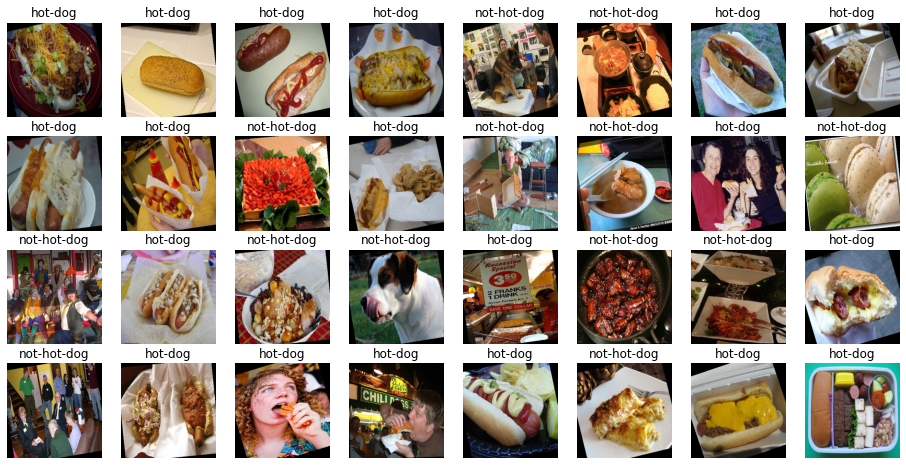

In [19]:
labels_map = {0 : 'hot-dog', 1 : 'not-hot-dog'}  

figure, axes = plt.subplots(nrows=4, ncols=8, figsize=(16, 8))
axes = axes.flatten()

for i in range(32):
    rand_i = np.random.randint(0, len(trainset))
    image = trainset[rand_i][0].permute(1, 2, 0)
    axes[i].axis('off')
    axes[i].imshow(image)
    axes[i].set_title(labels_map[trainset[rand_i][1]])   

3. 데이터 적재

In [20]:
batch_size = 16
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True) 
validloader = DataLoader(validset, batch_size=batch_size, shuffle=False) 
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False) 

In [21]:
print(type(trainloader), len(trainloader))
print(type(validloader), len(validloader))
print(type(testloader), len(testloader))

<class 'torch.utils.data.dataloader.DataLoader'> 150
<class 'torch.utils.data.dataloader.DataLoader'> 38
<class 'torch.utils.data.dataloader.DataLoader'> 41


In [22]:
train_iter = iter(trainloader)
images, labels = next(train_iter)
print(images.size(), labels.size())

torch.Size([16, 3, 299, 299]) torch.Size([16])


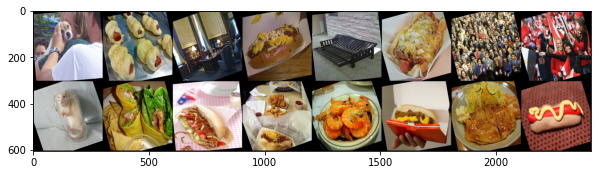

In [23]:
gird_img = torchvision.utils.make_grid(images)
plt.figure(figsize=(10, 100))
plt.imshow(gird_img.permute(1, 2, 0))

### 4. 모델생성

In [24]:
from torch import nn 
from torch import optim
import torch.nn.functional as F 

In [25]:
import torchvision.models as models
model = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [26]:
w = torch.empty(3, 5)
nn.init.kaiming_normal_(w, mode='fan_out', nonlinearity='relu')

tensor([[-0.3839,  0.0293,  0.0587,  0.6692, -0.0855],
        [ 0.3068,  0.7587, -0.8649,  0.2810,  0.5023],
        [-0.0961,  0.0981,  1.1094, -0.6869, -0.2326]])

In [27]:
import math
b = torch.empty(3)
bound = 1 / math.sqrt(w.size(1))
nn.init.uniform_(b, -bound, bound)

tensor([-0.2051, -0.0927,  0.0738])

In [28]:
model.fc = nn.Sequential(nn.Linear(512, 256),
                         nn.ReLU(),
                         nn.Dropout(0.2),
                         nn.Linear(256, 2),
                         nn.LogSoftmax(dim=1))

In [29]:
#model = ResNet()
model.to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [30]:
!pip install torchsummary

In [31]:
from torchsummary import summary

In [32]:
summary(model, (3, 299, 299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 150, 150]           9,408
       BatchNorm2d-2         [-1, 64, 150, 150]             128
              ReLU-3         [-1, 64, 150, 150]               0
         MaxPool2d-4           [-1, 64, 75, 75]               0
            Conv2d-5           [-1, 64, 75, 75]          36,864
       BatchNorm2d-6           [-1, 64, 75, 75]             128
              ReLU-7           [-1, 64, 75, 75]               0
            Conv2d-8           [-1, 64, 75, 75]          36,864
       BatchNorm2d-9           [-1, 64, 75, 75]             128
             ReLU-10           [-1, 64, 75, 75]               0
       BasicBlock-11           [-1, 64, 75, 75]               0
           Conv2d-12           [-1, 64, 75, 75]          36,864
      BatchNorm2d-13           [-1, 64, 75, 75]             128
             ReLU-14           [-1, 64,

5. 모델 컴바인

In [33]:
learning_rate = 0.00001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [34]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=7, factor=0.1, verbose=True)

6. 모델훈련(with 검증)

In [35]:
def validation(model, validloader, criterion):
    valid_accuracy = 0
    valid_loss = 0

    with torch.no_grad():
        for images, labels in validloader:
            images, labels = images.to(device), labels.to(device)
            logits = model.forward(images) # 점수 반환
            _, preds = torch.max(logits, 1) # 16개에 대한 최종 예측
            correct = (preds == labels).sum()
            accuracy = correct / images.shape[0]
            loss = criterion(logits, labels) # 16개에 대한 loss
      
            valid_accuracy += accuracy
            valid_loss += loss.item() # tensor 값을 꺼내옴
        

    return valid_loss, valid_accuracy 

In [36]:
from torch.utils.tensorboard import SummaryWriter
writer  = SummaryWriter()

In [37]:
def train(model, epochs, criterion, optimizer):
    steps = 0
    min_loss = 10000
    max_accuracy = 0
    trigger = 0
    patience = 10 # for Early stopping
    
    train_loss_list = []
    valid_loss_list = []
    valid_acc_list = []
    
    # 1 에폭(epoch)당 반복수
    #steps_per_epoch = len(trainset)/batch_size 
    steps_per_epoch = len(trainloader) 

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, labels in iter(trainloader):
            steps += 1
            images, labels = images.to(device), labels.to(device)
            outputs = model.forward(images) # 예측
            loss = criterion(outputs, labels) # 예측과 결과를 통해 Cross Entropy Loss 반환
            optimizer.zero_grad() # 파이토치에서 gradient가 누적되지 않게 하기 위해
            loss.backward()
            optimizer.step() # W <- W -lr*Gradient

            train_loss += loss.item()
            if (steps % steps_per_epoch) == 0:
                model.eval() # 배치 정규화, 드롭아웃이 적용될 때는 model.forward 연산이 training때와 다르므로 반드시 설정
                valid_loss, valid_accuracy = validation(model, validloader, criterion)
                
                ###
                train_loss_list.append(train_loss/len(trainloader))
                valid_loss_list.append(valid_loss/len(validloader))
                valid_acc_list.append(valid_accuracy/len(validloader))
                # tensorboad 시각화
                writer.add_scalar("Loss/train", train_loss/len(trainloader), epoch)
                writer.add_scalar("Loss/valid", valid_loss/len(validloader), epoch)
                writer.add_scalars("Loss/train and valid",
                                  {'train' : train_loss/len(trainloader),
                                   'valid' : valid_loss/len(validloader)}, epoch)
        
                writer.add_scalar("Valid Accuracy", valid_accuracy/len(validloader), epoch)


                print('Epoch : {}/{}.....'.format(epoch+1, epochs),
                      'Train Loss : {:.3f}'.format(train_loss/len(trainloader)),
                      'Valid Loss : {:.3f}'.format(valid_loss/len(validloader)),
                      'Valid Accuracy : {:.3f}'.format(valid_accuracy/len(validloader)))
        
                # Best model 저장
                if valid_accuracy > max_accuracy: 
                    max_accuracy = valid_accuracy
                    torch.save(model.state_dict(), 'best_checkpoint.pth')

                # Early Stopping 
                if valid_loss > min_loss:
                    trigger += 1 # valid loss가 min_loss 를 갱신하지 못할때마다 증가
                    print('trigger : ', trigger )
                    if trigger > patience:
                        print('Early Stopping!!!')
                        print('Traning step is finished!!')
                        writer.flush()  
                        return   
                    else:
                        trigger = 0
                        min_loss = valid_loss

                    train_loss = 0
                    model.train()
                    # Learning Rate Scheduler
                    scheduler.step(valid_loss)
        writer.flush()      

In [38]:
epochs=55
train(model, epochs, criterion, optimizer)

Epoch : 1/55..... Train Loss : 0.537 Valid Loss : 0.350 Valid Accuracy : 0.901
Epoch : 2/55..... Train Loss : 0.314 Valid Loss : 0.219 Valid Accuracy : 0.926
Epoch : 3/55..... Train Loss : 0.226 Valid Loss : 0.180 Valid Accuracy : 0.934
Epoch : 4/55..... Train Loss : 0.176 Valid Loss : 0.160 Valid Accuracy : 0.938
Epoch : 5/55..... Train Loss : 0.151 Valid Loss : 0.147 Valid Accuracy : 0.944
Epoch : 6/55..... Train Loss : 0.121 Valid Loss : 0.150 Valid Accuracy : 0.936
Epoch : 7/55..... Train Loss : 0.089 Valid Loss : 0.149 Valid Accuracy : 0.931
Epoch : 8/55..... Train Loss : 0.089 Valid Loss : 0.139 Valid Accuracy : 0.947
Epoch : 9/55..... Train Loss : 0.078 Valid Loss : 0.148 Valid Accuracy : 0.939
Epoch : 10/55..... Train Loss : 0.067 Valid Loss : 0.136 Valid Accuracy : 0.954
Epoch : 11/55..... Train Loss : 0.053 Valid Loss : 0.152 Valid Accuracy : 0.938
Epoch : 12/55..... Train Loss : 0.051 Valid Loss : 0.137 Valid Accuracy : 0.939
Epoch : 13/55..... Train Loss : 0.036 Valid Loss 

In [39]:
%load_ext tensorboard

In [40]:
%tensorboard --logdir=runs

In [41]:
writer.close()

## 7. 모델 예측

In [42]:
test_iter = iter(testloader)
images, labels = next(test_iter)
images, labels = images.to(device), labels.to(device)
print(images.size(), labels.size())

torch.Size([16, 3, 299, 299]) torch.Size([16])


In [43]:
rnd_idx = 10
images[rnd_idx:rnd_idx+1].shape, labels[rnd_idx:rnd_idx+1] # 1, 3, 32, 32

(torch.Size([1, 3, 299, 299]), tensor([0], device='cuda:0'))

In [44]:
img = images[rnd_idx:rnd_idx+1]
with torch.no_grad():
    model.eval() # 배치 정규화가 들어가면서 전방향 연산이 학습시와는 달라지므로 반드시 eval() 넣어야 함
    logit = model.forward(img)

pred = logit.max(dim=1)[1]
pred == labels[rnd_idx]

tensor([True], device='cuda:0')

In [45]:
pred, labels[rnd_idx] # 예측 0(hot-dog), 정답 0(hot-dog)

(tensor([0], device='cuda:0'), tensor(0, device='cuda:0'))

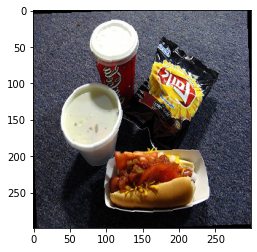

In [46]:
img = img.cpu()
plt.imshow(img[0].permute(1, 2, 0)) 

### 8. 모델 평가

In [47]:
def evaluation(model, testloader, criterion):
    test_accuracy = 0
    test_loss = 0

  # 전방향 예측을 구할 때는 gradient가 필요가 없음
    with torch.no_grad():
        model.eval()
        for images, labels in testloader: 
            images, labels = images.to(device), labels.to(device)
            logits = model.forward(images) # 점수 반환
            _, preds = torch.max(logits, 1) # 16개에 대한 최종 예측
            correct = (preds == labels).sum()
      
            accuracy = correct / images.shape[0]
            loss = criterion(logits, labels) # 16개에 대한 loss
      
            test_accuracy += accuracy.item()
            test_loss += loss.item() # tensor 값을 꺼내옴
        
    print('Test Loss : ', test_loss/len(testloader))
    print('Test Accuracy : ', test_accuracy/len(testloader))

In [48]:
evaluation(model, testloader, criterion)

Test Loss :  0.2383328107020267
Test Accuracy :  0.9344512195121951


9. 모델 저장

In [49]:
torch.save(model.state_dict(), 'last_checkpoint.pth')

In [50]:
last_state_dict = torch.load('last_checkpoint.pth')
last_state_dict.keys()

odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.weight', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer1.1.bn2.running_mean', 'layer1.1.bn2.running_var', 'layer1.1.bn2.num_batches_tracked', 'layer2.0.conv1.weight', 'layer2.0.bn1.weight', 'layer2.0.bn1.bias', 'layer2.0.bn1.running_mean', 'layer2.0.bn1.running_var', 'layer2.0.bn1.num_batches_tracked', 'layer2.0.conv2.weight', 'layer2.0.bn2.weight', 'layer2.0.bn2.bias', '

In [51]:
#last_model = ResNet()

last_model = model
last_model.to(device)
last_model.load_state_dict(last_state_dict)

<All keys matched successfully>

In [52]:
evaluation(last_model, testloader, criterion)

Test Loss :  0.21937778660219742
Test Accuracy :  0.9435975609756098


In [53]:
best_state_dict = torch.load('best_checkpoint.pth')

In [54]:
#best_model = ResNet()

best_model = model
best_model.to(device)
best_model.load_state_dict(best_state_dict)

<All keys matched successfully>

In [55]:
evaluation(best_model, testloader, criterion)

Test Loss :  0.22311817279096874
Test Accuracy :  0.9375
